# Notebook devoted mostly to Chapter 4

In order to reload packages that change within a session.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, matplotlib.pyplot as plt, numpy as np, pandas as pd, networkx as nx
from io import StringIO

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

sys.path.append('../Teaching/')
import draw_NX as qnx
import signatures as s

Joaquim synchronizes his `dropbox` with overleaf, that is the reason why the path below is important when Joaquim is running this notebook!
Consider modifying it to your convenience. 

In [3]:
qnx.SetOutputPath( r'D:\joaquimg\Dropbox\Apps\Overleaf\Optimization textbook\figures\ch4\generated' )

In [4]:
def GetFullName( file_name, main_path = qnx._output_path ):
    if file_name:
        return f'{main_path}{file_name}.pdf'
    return file_name

# Examining the armory

`networkx` comes with a wealth of drawing ingredients. 
Each of our figures can be easily drawn, one by one, the challenge is to limit the code duplication in order to ease possible future adjustments. 
Let us start by inspecting the function signatures and what they have in common. 

In [5]:
family = [nx.draw,nx.draw_networkx,nx.draw_networkx_edge_labels,nx.draw_networkx_edges,nx.draw_networkx_labels,nx.draw_networkx_nodes]

The line below enables pasting the table to `excel`, for instance, to ease reference.

In [6]:
s.DisplayNamedArguments(family).to_clipboard()

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None ):
    display(s.DisplayNamedArguments(family))

,draw,draw_networkx,draw_networkx_edge_labels,draw_networkx_edges,draw_networkx_labels,draw_networkx_nodes
alpha,,,None,None,None,None
arrows,,None,,None,,
arrowsize,,,,10,,
arrowstyle,,,,None,,
ax,None,,None,None,None,None
bbox,,,None,,None,
clip_on,,,True,,True,
cmap,,,,,,None
connectionstyle,,,,'arc3',,
edge_cmap,,,,None,,


In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None ):
    display(s.DisplayPositionalArguments(family))

,draw,draw_networkx,draw_networkx_edge_labels,draw_networkx_edges,draw_networkx_labels,draw_networkx_nodes
0,G,G,G,G,G,G
1,,,pos,pos,pos,pos


Of course that you may just prefer to open the help pages of each of those methods on your browser...

# Design

The design follows a template method pattern implemented in `qnx.Draw`. 
The steps taken are a list of tuples each with a function and the arguments that deviate from the default. 
The template method ensures that the graph `G` and the node positions `pos` are consistently passed through.

Each individual figure is therefore drawn by listing the steps. 

Some figures (e.g. flow based) share structure. 

`qnx` also includes utility functions to generate graphs from data frames and to nudge coordinates provided a cardinal direction encoding. 

# Our figures

In [9]:
def DinaNet():
    m = (6, 8, 2, 9, 13, 1)
    c = (8, 8, 10, 4, 9)
    k = 3
    G = nx.DiGraph()
    G.add_node( 'door', layer=0 )
    for i in range(len(m)):
        G.add_node( f'f{i}', layer=1, label=f'$f_{i}$' )
    for j in range(len(c)):
        G.add_node( f't{j}', layer=2, label=f'$t_{j}$' )
    G.add_node( 'seat', layer=3 )
    for i,f in enumerate(m):
        G.add_edge( 'door', f'f{i}', capacity=f )
    for j,t in enumerate(c):
        G.add_edge( f't{j}', 'seat', capacity=t )
    for i in range(len(m)):
        for j in range(len(c)):
            G.add_edge( f'f{i}', f't{j}', capacity=k )
    return G

In [10]:
pd.DataFrame.from_dict(nx.maximum_flow(DinaNet(),'door','seat')[-1],orient='index').fillna('')

,f0,f1,f2,f3,f4,f5,t0,t1,t2,t3,t4,seat
door,6.0,8.0,2.0,9.0,13.0,1.0,,,,,,
f0,,,,,,,3.0,0.0,0.0,0.0,3.0,
f1,,,,,,,0.0,2.0,3.0,1.0,2.0,
f2,,,,,,,0.0,0.0,1.0,0.0,1.0,
f3,,,,,,,1.0,3.0,3.0,0.0,2.0,
f4,,,,,,,3.0,3.0,3.0,3.0,1.0,
f5,,,,,,,1.0,0.0,0.0,0.0,0.0,
t0,,,,,,,,,,,,8.0
t1,,,,,,,,,,,,8.0
t2,,,,,,,,,,,,10.0


In [11]:
def DinaModelSteps( G, pos ):
    node_size = 800
    all_edge_labels = nx.get_edge_attributes(G,'capacity')
    edges_with_rotated_labels = { (u,v) for (u,v) in G.edges if u == 'door' or v == 'seat' }
    rotated_edge_labels = { e : l for e,l in all_edge_labels.items() if e in edges_with_rotated_labels }
    vertical_edge_labels = { e : l for e,l in all_edge_labels.items() if not e in edges_with_rotated_labels }
    functions = [ ( nx.draw_networkx_nodes, { 'node_size' : node_size } )
                ,( nx.draw_networkx_edges, dict( node_size=node_size, width=.2 ) )
                ,( nx.draw_networkx_edge_labels, { 'bbox' : dict(boxstyle='round4', facecolor='white', alpha=None, edgecolor='red'), 'edge_labels' : rotated_edge_labels, 'rotate' : True } )
                ,( nx.draw_networkx_edge_labels, dict( bbox=dict(boxstyle='circle', facecolor='white', alpha=None, edgecolor='orange'), edge_labels=vertical_edge_labels, rotate=False ) )
                ,( nx.draw_networkx_labels, { 'font_color' : 'white', 'font_size' : 13, 'labels' : nx.get_node_attributes( G, 'label' ) } ) 
                ,( nx.draw_networkx_labels, { 'font_color' : 'yellow', 'font_size' : 10, 'labels' : { 'door' : 'door', 'seat' : 'seat' } } ) 
                ]
    return functions

In [12]:
def DinaSolutionSteps( G, pos ):
    flow = nx.maximum_flow(G,'door','seat')
    F = { (u,v) : flow[-1][u][v] for (u,v) in G.edges() }
    f = { (u,v) : flow[-1][u][v] for (u,v) in G.edges() if flow[-1][u][v] and not u == 'door' and not v == 'seat' }
    
    model_functions = DinaModelSteps( G, pos )
    node_size = model_functions[0][-1]['node_size']

    functions = [ ( nx.draw_networkx_edges, dict(width=list(F.values()), edge_color='lightblue', style='solid', alpha=None, arrowstyle='-', node_size=node_size) ) ] + \
                model_functions + \
                [ ( nx.draw_networkx_edge_labels, dict( edge_labels=f, rotate=True, label_pos=.85, font_size=6 ) ) ]
    return functions

In [13]:
def DrawDina():
    G = DinaNet()
    pos = nx.multipartite_layout(G,subset_key='layer')
    qnx.Draw( G, pos, DinaModelSteps(G,pos), file_name=GetFullName('dina_model') )    
    qnx.Draw( G, pos, DinaSolutionSteps(G,pos), file_name=GetFullName('dina_solution') )

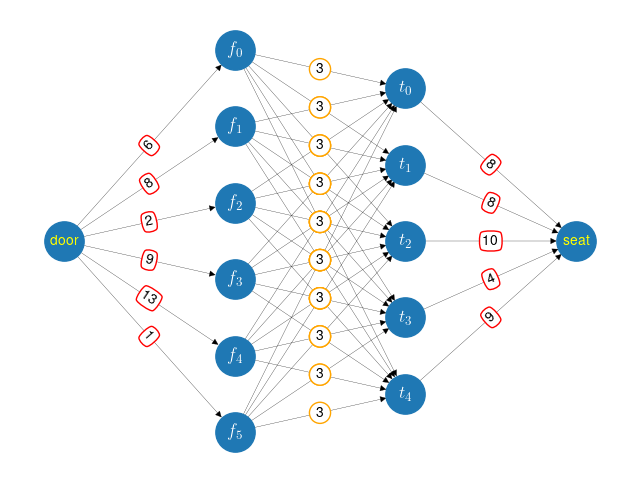

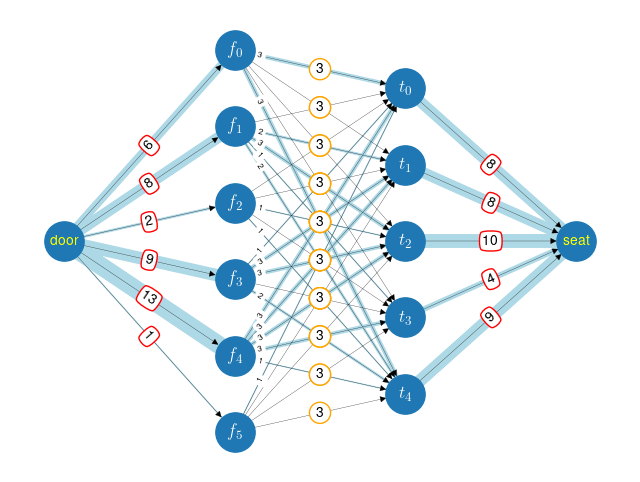

In [14]:
DrawDina()

In [15]:
def Fig4():
    nodes = '''
node,x,y,nudge,demand
a,0,1,'w',-1
b,1,2,'w',0
c,1,1,'sw',0
d,1,0,'w',-2
e,2,2,'e',2
f,2,1,'ne',0
g,2,0,'e',1
h,3,1,'e',0
'''

    edges = '''
from,to,cost
a,b,3
a,c,1
a,d,2
b,e,1
c,b,1
c,e,4
c,d,1
d,g,2
d,f,3
c,f,1
f,e,4
g,f,8
f,h,2
e,h,2
g,h,0
'''
    nodes = pd.read_csv(StringIO(nodes), sep=',', index_col='node').fillna(0)
    edges = pd.read_csv(StringIO(edges), sep=',', index_col=['from','to'])

    return  nodes, edges

In [16]:
def FlowModelSteps(G,pos,exceptional_label_positions=dict()):
    node_size = 400
    nudge = nx.get_node_attributes(G,'nudge')
    nudged = { n : qnx.Nudge(p,nudge[n],.15) for n,p in pos.items() }
    functions = [ ( nx.draw_networkx_nodes, dict( node_size=node_size ) )
                , ( nx.draw_networkx_labels, dict( font_color='white', font_size=13, labels={ n : f'${n}$' for n in G.nodes} ) ) 
                , ( nx.draw_networkx_labels, dict( pos=nudged, font_color='black', font_size=13, labels={ n : f'${d}$' for n,d in nx.get_node_attributes(G,'demand').items() } ) ) 
                , ( nx.draw_networkx_edges, dict( node_size=node_size, width=2 ) )
                ]
    edge_labels = nx.get_edge_attributes(G,'cost')
    for exception, label_pos in exceptional_label_positions.items():
        exceptional_edge = { exception : edge_labels[exception]}
        edge_labels.pop(exception)
        functions.append( ( nx.draw_networkx_edge_labels, dict(edge_labels=exceptional_edge, rotate=True, label_pos=label_pos ) ) )
    functions.append( ( nx.draw_networkx_edge_labels, dict(edge_labels=edge_labels, rotate=True ) ) )

    return functions

In [17]:
def FlowSolutionSteps(G,pos,exceptional_label_positions=dict()):
    flow = nx.min_cost_flow(G,demand='demand',capacity='capacity',weight='cost')
    F = { (u,v) : flow[u][v] for (u,v) in G.edges() if flow[u][v] }
    edge_labels_with_flow = { (u,v) : rf'${flow[u][v]}\times{l}$' for (u,v),l in nx.get_edge_attributes(G,'cost').items() if flow[u][v] }
    
    model_functions = FlowModelSteps( G, pos, exceptional_label_positions )
    node_size = model_functions[0][-1]['node_size']

    functions = [ ( nx.draw_networkx_edges, dict( edgelist=F.keys(), width=10, edge_color='lightblue', style='solid', alpha=None, arrowstyle='-', node_size=node_size) ) ] + \
                model_functions 
                
    edge_labels = edge_labels_with_flow
    for exception, label_pos in exceptional_label_positions.items():
        if exception in edge_labels:
            exceptional_edge = { exception : edge_labels[exception]}
            edge_labels.pop(exception)
            functions.append( ( nx.draw_networkx_edge_labels, dict(edge_labels=exceptional_edge, rotate=True, label_pos=label_pos ) ) )
    functions.append( ( nx.draw_networkx_edge_labels, dict(edge_labels=edge_labels, rotate=True ) ) )
    return functions

In [18]:
def DrawFig4():
    G = qnx.FillGraphFromFrames( nx.DiGraph(), *Fig4() )
    pos = qnx.PosFromXY(G)
    qnx.Draw( G, pos, FlowModelSteps(G,pos), figsize=(8,5), file_name=GetFullName('fig4_model') )    
    qnx.Draw( G, pos, FlowSolutionSteps(G,pos), figsize=(8,5), file_name=GetFullName('fig4_solution') )

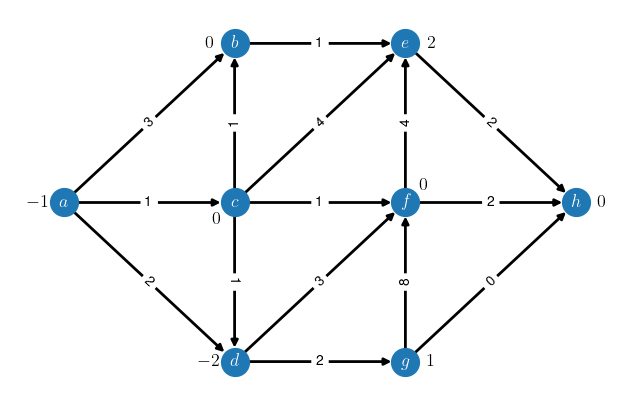

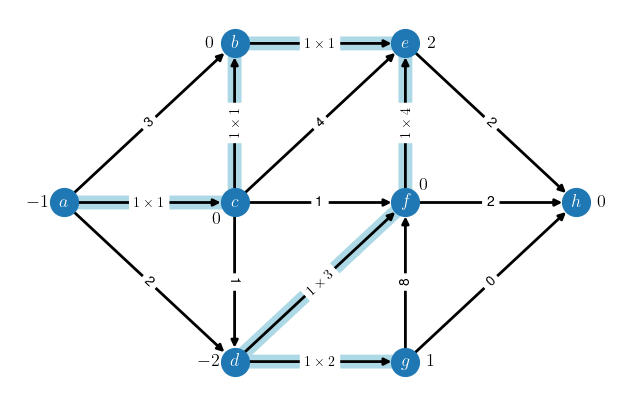

In [19]:
DrawFig4()

In [20]:
def Fig5():
    nodes = '''
node,x,y,nudge,demand
a,0,1,'w',-1
b,1,2,'w',0
c,1,0,'w',0
d,2,2,'e',0
e,2,0,'e',0
f,3,1,'e',1
'''

    edges = '''
from,to,cost
a,b,4
a,c,3
b,c,4
b,d,4
b,e,3
c,d,4
c,e,5
d,f,2
e,d,4
e,f,1
'''
    nodes = pd.read_csv(StringIO(nodes), sep=',', index_col='node').fillna(0)
    edges = pd.read_csv(StringIO(edges), sep=',', index_col=['from','to'])

    return  nodes, edges

In [21]:
def DrawFig5():
    G = qnx.FillGraphFromFrames( nx.DiGraph(), *Fig5() )
    pos = qnx.PosFromXY(G)
    exceptional_label_positions = { ('c','d') : .4, ('b','e') : .4 }
    qnx.Draw( G, pos, FlowModelSteps(G,pos,exceptional_label_positions), figsize=(8,5), file_name=GetFullName('fig5_model') )    
    qnx.Draw( G, pos, FlowSolutionSteps(G,pos,exceptional_label_positions), figsize=(8,5), file_name=GetFullName('fig5_solution') )

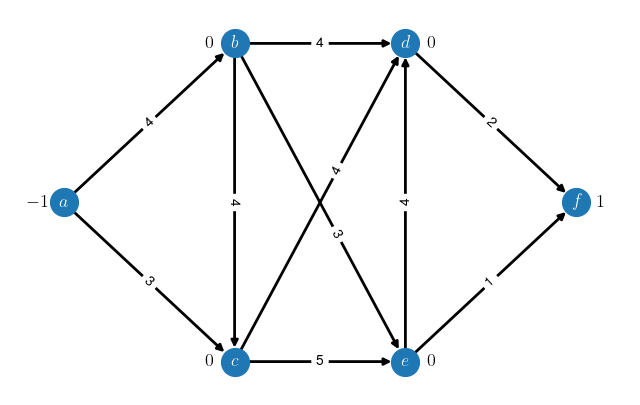

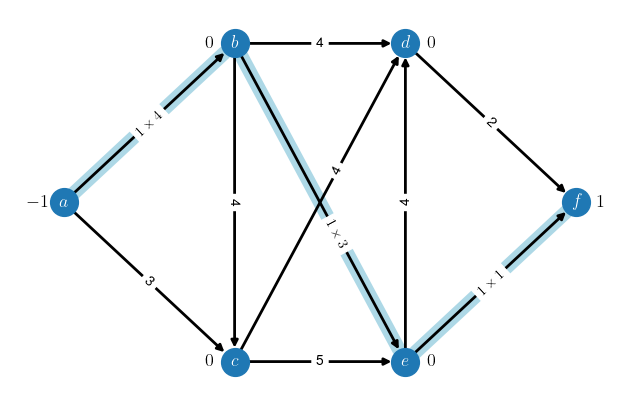

In [22]:
DrawFig5()

In [23]:
def Fig13(n,m):
    G = nx.DiGraph()
    I = list(range(1,n+1))
    J = list(range(1,m+1))
    for i in I:
        G.add_node(f's{i}', label=f'$s_{i}$',layer=1)    
    for j in J:
        G.add_node(f'd{j}', label=f'$d_{j}$',layer=2)
    for i in I:
        for j in J:
            G.add_edge(f's{i}',f'd{j}', label=f'$c_{{{i}{j}}}$')
    return G

In [24]:
def Fig13Steps(G):
    node_size = 800
    functions = [( nx.draw_networkx_nodes, dict(node_size=node_size) )
                ,( nx.draw_networkx_edges, dict(node_size=node_size) )
                ,( nx.draw_networkx_edge_labels, dict( rotate=True, label_pos=.35, font_size=12, edge_labels=nx.get_edge_attributes( G, 'label' ) ) )
                ,( nx.draw_networkx_labels, dict(font_color='white', font_size=13, labels=nx.get_node_attributes( G, 'label' ) ) ) 
                ]
    return functions

In [25]:
def DrawFig13():
    G = Fig13(2,3)
    pos = nx.multipartite_layout(G,subset_key='layer')
    qnx.Draw( G, pos, Fig13Steps(G), figsize=(8,5), file_name=GetFullName('fig13') )

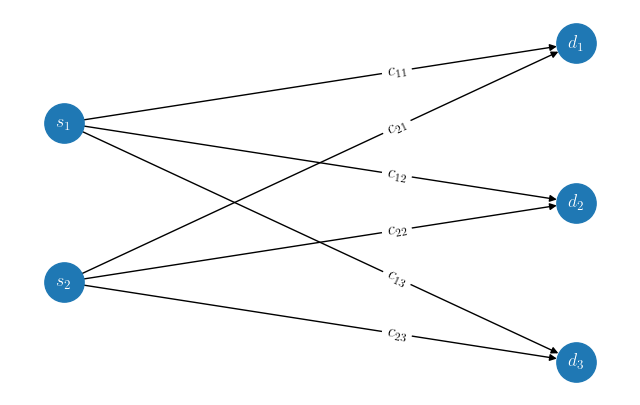

In [26]:
DrawFig13()

In [27]:
def Fig16():
    nodes = '''
node,nudge,demand,layer
a,'w',-1,1
b,'w',-1,1
c,'e',1,2
d,'e',1,2
'''

    edges = '''
from,to,cost
a,c,3
a,d,4
b,c,1
b,d,3
'''
    nodes = pd.read_csv(StringIO(nodes), sep=',', index_col='node').fillna(0)
    edges = pd.read_csv(StringIO(edges), sep=',', index_col=['from','to'])

    return  nodes, edges

In [28]:
G = qnx.FillGraphFromFrames( nx.DiGraph(), *Fig16() )
pos = nx.multipartite_layout(G,subset_key='layer')

In [29]:
def DrawFig16():
    G = qnx.FillGraphFromFrames( nx.DiGraph(), *Fig16() )
    pos = nx.multipartite_layout(G,subset_key='layer')
    exceptional_label_positions = { ('a','d') : .4, ('b','c') : .4 }
    qnx.Draw( G, pos, FlowModelSteps(G,pos,exceptional_label_positions), figsize=(8,5), file_name=GetFullName('fig16_model') )    
    qnx.Draw( G, pos, FlowSolutionSteps(G,pos,exceptional_label_positions), figsize=(8,5), file_name=GetFullName('fig16_solution') )

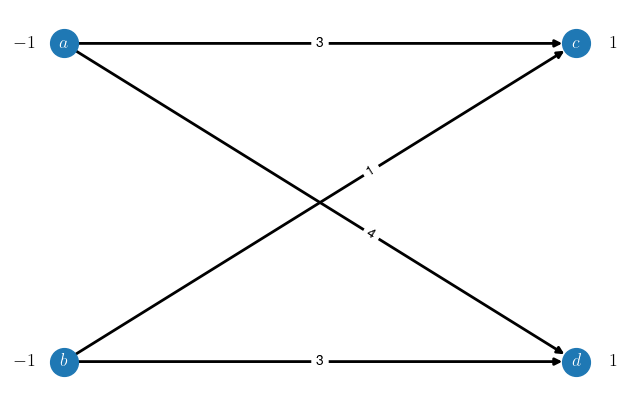

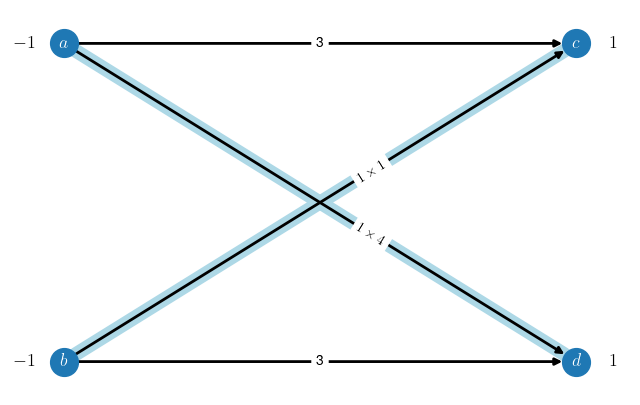

In [30]:
DrawFig16()

In [31]:
def Fig18():
    nodes = '''
node,layer
s,0
a,1
b,1
c,2
d,2
e,2
t,3
'''

    edges = '''
from,to,capacity
s,a,1
s,b,1
a,c,1
a,d,1
a,e,1
b,e,1
c,t,1
d,t,1
e,t,1
'''
    nodes = pd.read_csv(StringIO(nodes), sep=',', index_col='node').fillna(0)
    edges = pd.read_csv(StringIO(edges), sep=',', index_col=['from','to'])

    return  nodes, edges

In [32]:
def Fig18ModelSteps(G,pos):
    node_size = 400
    functions = [ ( nx.draw_networkx_nodes, { 'node_size' : node_size } )
                ,( nx.draw_networkx_edges, dict( node_size=node_size, width=1, arrowstyle='-' ) )
                ,( nx.draw_networkx_labels, { 'font_color' : 'white', 'font_size' : 13, 'labels' : { n : f'${n}$' for n in G.nodes } } ) 
                ]
    return functions

In [33]:
def Fig18SolutionSteps(G,pos):
    flow = nx.maximum_flow(G,'s','t')
    F = { (u,v) : flow[-1][u][v] for (u,v) in G.edges() }
    W = { (u,v) : 3*flow[-1][u][v] for (u,v) in G.edges() }

    node_size = 400
    all_edge_labels = nx.get_edge_attributes(G,'capacity')
    edges_with_rotated_labels = { (u,v) for (u,v) in G.edges if u == 's' or v == 't' }
    rotated_edge_labels = { e : l for e,l in all_edge_labels.items() if e in edges_with_rotated_labels }
    vertical_edge_labels = { e : l for e,l in all_edge_labels.items() if not e in edges_with_rotated_labels }
    functions = [ ( nx.draw_networkx_nodes, { 'node_size' : node_size } )
                ,( nx.draw_networkx_edges, dict( width=list(W.values() ), edge_color='lightblue', style='solid', alpha=None, arrowstyle='-', node_size=node_size) )
                ,( nx.draw_networkx_edges, dict( node_size=node_size, width=.2 ) )
                ,( nx.draw_networkx_edge_labels, { 'bbox' : dict(boxstyle='round4', facecolor='white', alpha=None, edgecolor='red'), 'edge_labels' : rotated_edge_labels, 'rotate' : True } )
                ,( nx.draw_networkx_edge_labels, dict( bbox=dict(boxstyle='circle', facecolor='white', alpha=None, edgecolor='orange'), edge_labels=vertical_edge_labels, rotate=False ) )
                ,( nx.draw_networkx_edge_labels, dict( edge_labels=F, rotate=True, label_pos=.85, font_size=6 ) )
                ,( nx.draw_networkx_labels, { 'font_color' : 'white', 'font_size' : 13, 'labels' : { n : f'${n}$' for n in G.nodes } } ) 
                ]
    return functions

In [34]:
def DrawFig18():
    G = qnx.FillGraphFromFrames( nx.DiGraph(), *Fig18() )
    pos = nx.multipartite_layout(G,subset_key='layer')
    g = G.subgraph(list('abcde'))
    qnx.Draw( g, pos, Fig18ModelSteps(g,pos), figsize=(8,5), file_name=GetFullName('fig18_model') )
    qnx.Draw( G, pos, Fig18SolutionSteps(G,pos), figsize=(8,5), file_name=GetFullName('fig18_solution') )

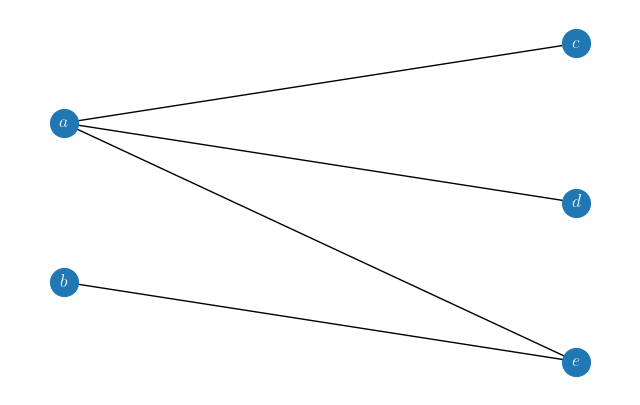

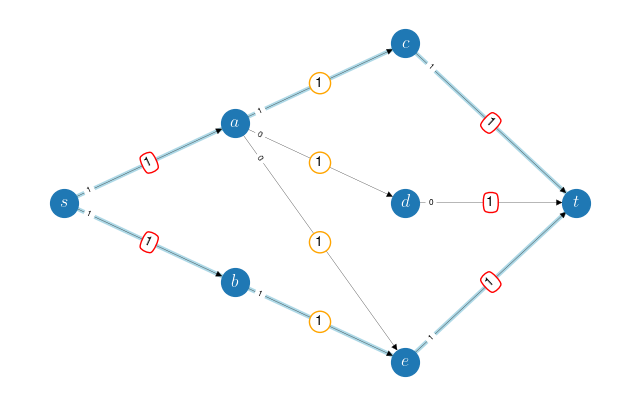

In [35]:
DrawFig18()

In [36]:
def Fig19():
    nodes = '''
node,layer
a,1
b,2
c,2
d,3
e,3
f,4
'''

    edges = '''
from,to
a,b
a,c
b,c
b,d
c,e
d,e
d,f
'''
    nodes = pd.read_csv(StringIO(nodes), sep=',', index_col='node')
    edges = pd.read_csv(StringIO(edges), sep=',', index_col=['from','to'])

    return  nodes, edges

In [37]:
G = qnx.FillGraphFromFrames( nx.Graph(), *Fig19() )
pos = nx.multipartite_layout(G,subset_key='layer')

In [38]:
def Fig19ModelSteps(G,pos):
    node_size = 400
    functions = [ ( nx.draw_networkx_nodes, { 'node_size' : node_size } )
                ,( nx.draw_networkx_edges, dict( node_size=node_size, width=1 ) )
                ,( nx.draw_networkx_labels, { 'font_color' : 'white', 'font_size' : 13, 'labels' : { n : f'${n}$' for n in G.nodes } } ) 
                ]
    return functions

In [39]:
def Fig19SolutionSteps(G,pos):
    M = nx.maximal_matching(G)
    
    model_functions = Fig19ModelSteps( G, pos )
    node_size = model_functions[0][-1]['node_size']
    return [( nx.draw_networkx_edges, dict( edgelist=M, width=8, edge_color='lightblue', style='solid', alpha=None, arrowstyle='-', node_size=node_size) )] + model_functions

In [40]:
def DrawFig19():
    G = qnx.FillGraphFromFrames( nx.Graph(), *Fig19() )
    pos = nx.multipartite_layout(G,subset_key='layer')
    qnx.Draw( G, pos, Fig19ModelSteps(G,pos), figsize=(5,3), file_name=GetFullName('fig19_model') )
    qnx.Draw( G, pos, Fig19SolutionSteps(G,pos), figsize=(5,3), file_name=GetFullName('fig19_solution') )

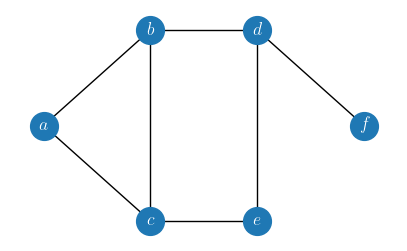

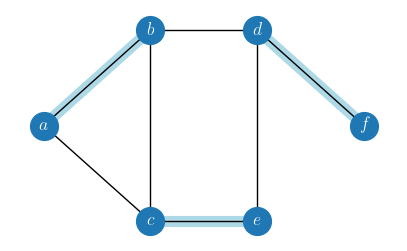

In [41]:
DrawFig19()